### <b>Portfolio Assignment</b>
#### <b>Data Mining. Community Discovery.</b>
The work is done by Ilia Semenok.
##### <b>Task 1. Context </b>

I'm a data scientist working for the city hall of Dnipro (Ukraine). <br>
1. I was hired to find districts, regions of the modern Dnipto city's road network. <br>
2. The city's districts were last updated a long time ago and now their boundaries need to be revised to take into account contemporary requirements. <br>
Currently the city is divided into 8 districts. I think it's not enough and I want to split the city into more areas.
3. I will also try to detect bottlenecks between regions as they represent high-traffic roads and therefore important in the road network.
4. I hope my findings can improve the analysis of transport and infrastructure planning.
5. Social and economic surveys could be conducted in order to gather insights like population size, age distribution, income levels etc.

##### <b>Task 2. The Data </b> <br>
My graph dataset is a road network of city Dnipro where nodes represent interceptions and endpoints and <br>
edges between them represent roads with weights as road lengths. The graph is undirected. <br>
It has 7677 nodes and 10880 edges. <br>
The data was downloaded from the “osmnx” library, which in turn takes this data from OpenStreetMap (OSM) website. <br>

Here is the link to see how the city looks like: <br>
https://www.openstreetmap.org/relation/1017311

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Download the road network (drivable roads).
G = ox.graph_from_place("Dnipro, Ukraine", network_type='drive')

# Add edge weights based on the length of roads.
for u, v, data in G.edges(data=True):
    data['weight'] = data.get('length', 1)  # Use road length as weight.

# ox.save_graphml(G, "dnipro_road_network_origin.graphml") needed for later!

# Print basic statistics:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")      # Number of nodes and edges differ from the ones I mentioned,
print(f"Number of edges: {num_edges}")      # because preprocessing hasn't been done yet.

Number of nodes: 7677
Number of edges: 20500


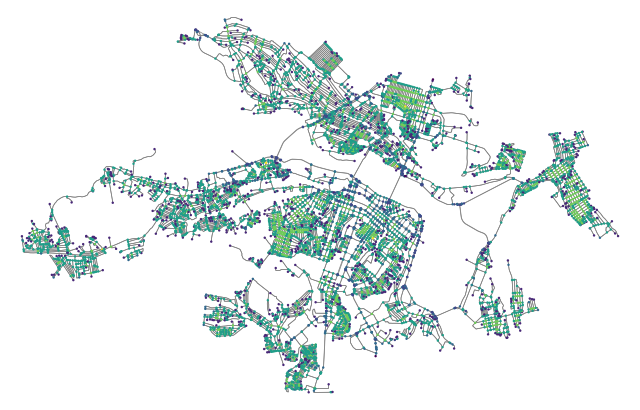

In [2]:
# to visualize the city and the nodes on it, just to get the idea of how the actual city looks like in real life.
# this colors the nodes based on how many edges connect to them. It's not necessary though.
node_degrees = dict(G.degree())
node_colors = [node_degrees[node] for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,  # color nodes based on their degree.
    node_size=3,
    edge_color="gray",
    edge_linewidth=0.5,
    bgcolor="white"
)

On the graph above we can see how <b>Dnipro's geographical structure</b> looks like. <br>
However, the data is directed at the moment. It needs to be turned into undirected graph. Along with that, some preprocessing will take place.

##### <b> Task 3. Initial Data Analysis and Preprocessing </b>

In [3]:
# Create a new graph with only nodes, edges and weights.
H = nx.Graph()  # create an empty graph using networkx.

# Add nodes to the new graph.
H.add_nodes_from((node, {}) for node in G.nodes())

# Add edges with only the weight attribute.
for u, v, data in G.edges(data=True):
    weight = data.get('weight', 1)  # default weight is 1 if missing.
    H.add_edge(u, v, weight=weight)

print(f"Sample edge data: {list(H.edges(data=True))[:2]}")

Sample edge data: [(27123266, 300564704, {'weight': 250.10977634764447}), (27123266, 346438620, {'weight': 284.305460670271})]


In [4]:
print("Sample nodes:", list(G.nodes())[:2])                 # just to see some nodes.

# Iterate through all edges and convert weights to integers.
for u, v, data in H.edges(data=True):
    data['weight'] = round(float(data['weight']))

print("Sample edge data:", list(H.edges(data=True))[:2])    # verify edge weights.

Sample nodes: [27123266, 27123267]
Sample edge data: [(27123266, 300564704, {'weight': 250}), (27123266, 346438620, {'weight': 284})]


In [5]:
# Generate a mapping: original node -> shorter ID
short_mapping = {node: i for i, node in enumerate(H.nodes())}

# Replace node names in the graph
G_relabelled = nx.relabel_nodes(H, short_mapping)

# Confirm the relabeling
print(f"Graph relabeled with {G_relabelled.number_of_nodes()} nodes and {G_relabelled.number_of_edges()} edges.")

print("Sample nodes:", list(G_relabelled.nodes())[:2])  # Display some nodes.
print("Sample edge weights:", [data['weight'] for _, _, data in G_relabelled.edges(data=True)][:2])

Graph relabeled with 7677 nodes and 10889 edges.
Sample nodes: [0, 1]
Sample edge weights: [250, 284]


In [ ]:
# import json          needed for later!

# # Save the short_mapping dictionary to a JSON file
# with open('short_mapping.json', 'w') as f:
#     json.dump(short_mapping, f)

In [ ]:
# This is what I did:
# import pickle

# # Save the graph to a pickle file
# with open("graph_dnipro_pickle.pkl", "wb") as f:
#     pickle.dump(G_relabelled, f)

Up until now I turned my graph into undirected one, turned my weights into integers and relabeled my long node names into shorter ones. <br>
I saved this new simplified graph as "graph_dnipro_pickle.pkl".

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

with open("graph_dnipro_pickle.pkl", "rb") as f:  # Loading this simplified graph back to python.
    G = pickle.load(f)

print("Graph loaded from pickle format.")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph loaded from pickle format.
Graph has 7677 nodes and 10889 edges.


Loading simplified and preprocessed graph back in the code. <br>
Let's investigate if the graph contains self-loops and if so, let's visualize them.

In [2]:
# a list of self-loop edges with weights.
self_loops_with_weights = [(node, data['weight']) for node, _, data in G.edges(data=True) if node == _]

# self-loops with weights.
if self_loops_with_weights:
    print(f"The graph has {len(self_loops_with_weights)} self-loops with weights:")
    for loop in self_loops_with_weights:
        print(loop)

The graph has 9 self-loops with weights:
(1498, 451)
(2610, 209)
(3365, 450)
(4439, 172)
(5794, 212)
(5838, 376)
(5839, 324)
(6067, 226)
(7314, 71)


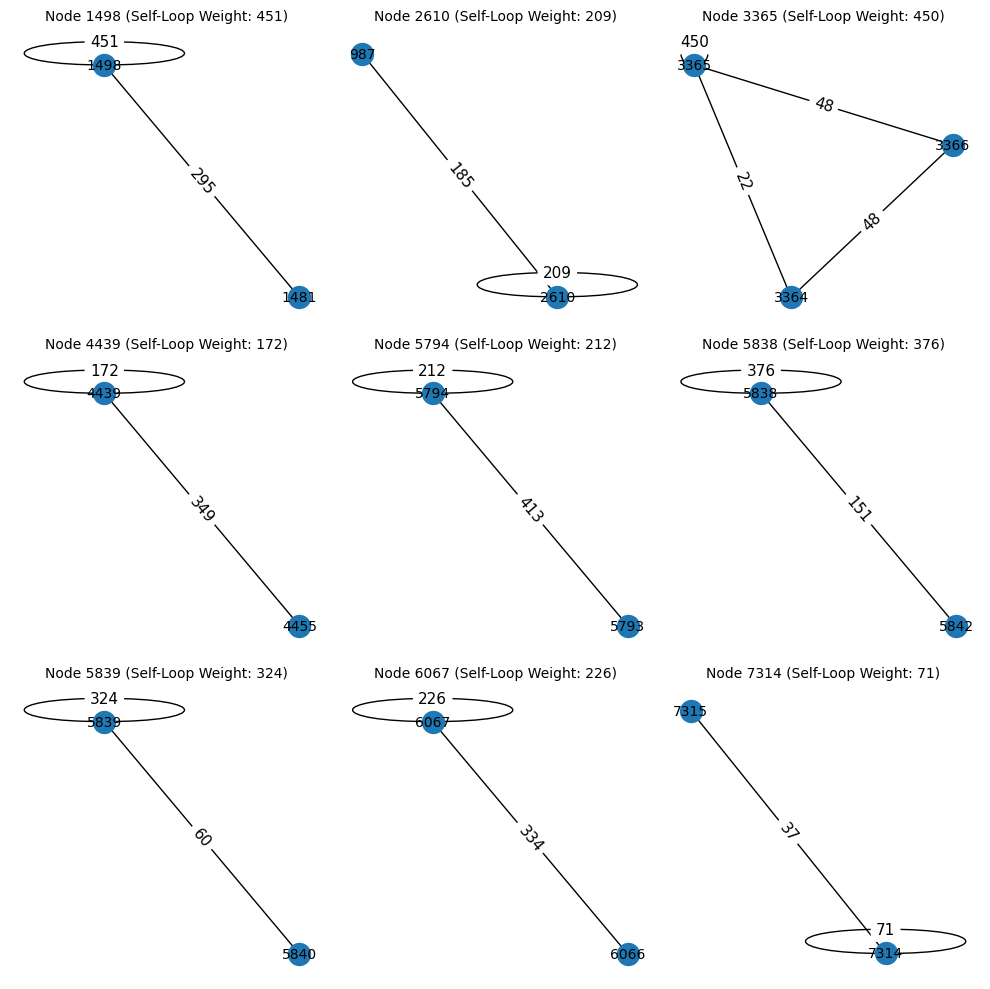

In [3]:
# create a subplot for each self-loop node's ego network.
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  
axes = axes.flatten()

# iterate through self-loop nodes
for i, (node, weight) in enumerate(self_loops_with_weights):
    
    # ego network for the self-loop node.
    ego_network = nx.ego_graph(G, node, radius=1)
    
    # edge weights for labeling.
    edge_labels = nx.get_edge_attributes(ego_network, 'weight')
    
    # draw the ego network.
    pos = nx.spring_layout(ego_network, seed=86)  
    nx.draw(ego_network, pos, ax=axes[i], with_labels=True, node_size=250, font_size=10)
    
    # draw edge labels (weights).
    nx.draw_networkx_edge_labels(ego_network, pos, edge_labels=edge_labels, ax=axes[i], font_size=11)
    
    # set the title with the self-loop weight.
    axes[i].set_title(f'Node {node} (Self-Loop Weight: {weight})', fontsize=10)

plt.tight_layout()
plt.show()

In my opinion these self-loops don't make any sense. Besides, the weights (road lengths) are too high for them to be considered <br>
circular intersections or roundabouts. This is why I'm going to delete them.

In [4]:
G.remove_edges_from(nx.selfloop_edges(G))
print("All self-loops have been removed.")
print(f"{G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
# Previously it was 7677 nodes and 10889 edges.. So, indeed 9 edges have been removed.

All self-loops have been removed.
7677 nodes and 10880 edges.


Finally all the preprocessing is done. <br>
My final number of <b>nodes: 7677</b> and my <b>edges: 10 880</b>. <br>
##### <b> Task 4. Graph Properties </b>

In [5]:
if G.is_directed():
    print("The graph is directed.")
else:
    print("The graph is undirected.")
    
is_connected = nx.is_connected(G)
print(f"Is the graph connected? {is_connected}")

The graph is undirected.
Is the graph connected? True


In [6]:
degrees = [d for _, d in G.degree()]
print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
print(f"Minimum degree: {min(degrees)}")
print(f"Maximum degree: {max(degrees)}")

Average degree: 2.83
Minimum degree: 1
Maximum degree: 6


In [7]:
num_components = nx.number_connected_components(G)   # My graph is connected but this is just for making sure.
largest_cc = max(nx.connected_components(G), key=len)
LCC = G.subgraph(largest_cc)  # Largest Connected Component.

print(f"Number of connected components: {num_components}")
print(f"Size of the largest connected component: {len(LCC)}")

global_clustering = nx.transitivity(G)      # Global clustering coefficient.
avg_clustering = nx.average_clustering(G)   # Average clustering coefficient.
density = nx.density(G)                     # Density of the graph.
print(f"Global clustering coefficient: {global_clustering:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Density: {density:.6f}")

Number of connected components: 1
Size of the largest connected component: 7677
Global clustering coefficient: 0.0522
Average clustering coefficient: 0.0468
Density: 0.000369


In my case, my graph is fully connected and thus, Largest Connected Component (LCC) is the graph 𝐺 itself. <br>

The road network is extremely sparse, this is why Global Clustering Coefficient (Transitivity), Average clustering coefficient <br>
and Density are very low. It's normal and expected in my case. <br>

The similarity between global clustering and average clustering suggests that the tendency for clustering is <br> 
uniformly low across the graph, rather than being concentrated in specific regions.

In [8]:
avg_path_length = nx.average_shortest_path_length(G, weight='weight')  # including weights to account for the physical length.
diameter = nx.diameter(G, weight='weight')
print(f"Average shortest path length (weighted): {avg_path_length:.1f}")
print(f"Diameter (weighted): {diameter}")
# average_shortest_path_length: length of the longest shortest path between any two nodes in the graph.
# might look too big, but if we plot distribution of shortest path lengths we can see it's normal.

Average shortest path length (weighted): 14458.6
Diameter (weighted): 43014


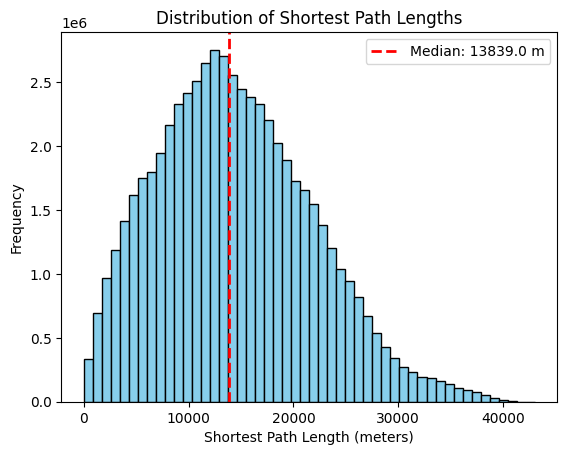

In [9]:
# compute all-pairs shortest path lengths.
all_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

# flatten the distances into a list.
distances = [dist for source in all_lengths.values() for dist in source.values()]
median_distance = np.median(distances)

plt.hist(distances, bins=50, color='skyblue', edgecolor='black')
plt.axvline(median_distance, color='red', linestyle='--', linewidth=2, label=f'Median: {median_distance:.1f} m')
plt.title("Distribution of Shortest Path Lengths")
plt.xlabel("Shortest Path Length (meters)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [10]:
# the list of edge weights (road lengths).
edge_weights = list(nx.get_edge_attributes(G, 'weight').values())

average_weight = np.mean(edge_weights)
median_weight = np.median(edge_weights)

print(f"Average edge weight (road length): {average_weight:.1f} meters")
print(f"Median edge weight (road length): {median_weight} meters")

Average edge weight (road length): 182.1 meters
Median edge weight (road length): 121.5 meters


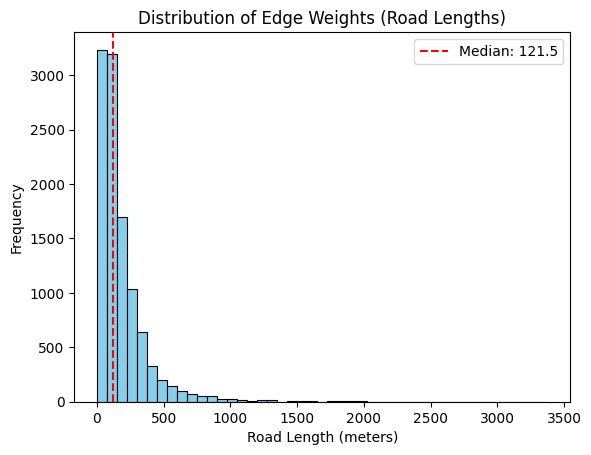

In [11]:
# Plot the distribution of edge weights.
plt.hist(edge_weights, bins=45, color='skyblue', edgecolor='black', linewidth=0.8)
plt.title("Distribution of Edge Weights (Road Lengths)")
plt.axvline(median_weight, color='red', linestyle='--', linewidth=1.5, label=f'Median: {median_weight:.1f}')
plt.xlabel("Road Length (meters)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

On the chart above we can see that the average road length between two nodes (intersections) is 182.1 meters and median of 121.5 meters.

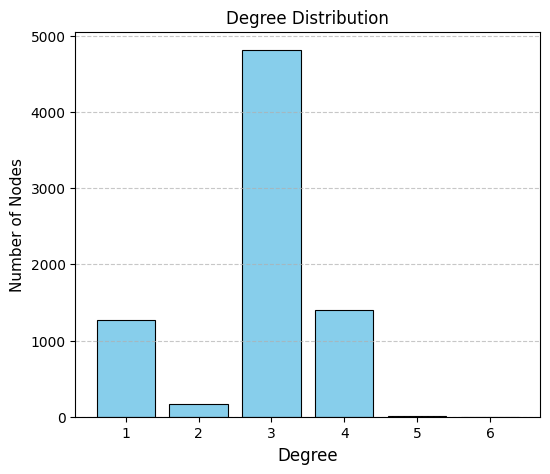

In [ ]:
from collections import Counter

degree_sequence = [d for _, d in G.degree()]  

# the occurrences of each degree.
degree_counts = Counter(degree_sequence)
degrees = sorted(degree_counts.keys())
counts = [degree_counts[d] for d in degrees]

plt.figure(figsize=(6, 5))
plt.bar(degrees, counts, color="skyblue", edgecolor="black", linewidth=0.8)

plt.gca().yaxis.grid(True, linestyle="--", alpha=0.7)  # Add gridlines
plt.title("Degree Distribution", fontsize=12)
plt.xlabel("Degree", fontsize=11)
plt.ylabel("Number of Nodes", fontsize=11)
plt.show()

In [13]:
# count the number of nodes for each degree to get the actual values.
degree_counts = pd.Series(degree_sequence).value_counts().sort_index()

# total number of nodes
total_nodes = len(degree_sequence)

for degree, count in degree_counts.items():
    percentage = (count / total_nodes) * 100
    print(f"There are {count} nodes ({percentage:.1f}%) with degree {degree}.")

There are 1268 nodes (16.5%) with degree 1.
There are 173 nodes (2.3%) with degree 2.
There are 4814 nodes (62.7%) with degree 3.
There are 1407 nodes (18.3%) with degree 4.
There are 14 nodes (0.2%) with degree 5.
There are 1 nodes (0.0%) with degree 6.


1) Most nodes <b>62.7%</b> in the graph have a <b>degree of 3</b>, meaning these are intersections where three roads meet. <br>
2) Which is typical in urban road networks. <br>
3) Nodes with a <b>degree of 4</b> indicate intersections where four roads meet, which is also quite normal.
4) <b>16.5%</b> of <b>1 degree</b> nodes represent dead ends or end points where roads end. They are usually found in city outskirts.
5) There are almost no nodes with <b>5 or 6 degree</b>, which makes sense, because it's rare to find such complex road junctions. <br>
6) Only <b>2.3%</b> of <b>2 degree nodes</b> which is also normal I guess.

***
Let's now plot node degree with respect to its node strength. <br>
Node strength shows the total road length connected to each intersection. <br>
1. low node strength: the node is at a city center with many short roads converging. But it could also be on the city's outskirts. <br>
2. high node strength: could indicate that many long roads meet at this node, which might occur at: <br>
    - A rural area or highway intersection (with fewer but longer roads). <br>
    - A major intersection in the city where several long roads converge.

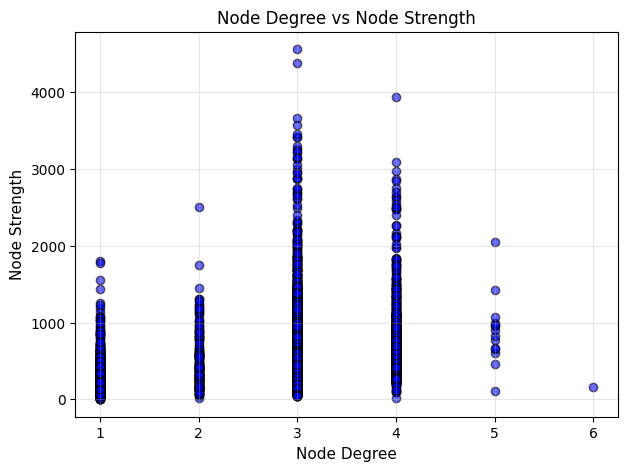

In [14]:
# find node strength for each node.
node_strength = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}
node_degree = dict(G.degree())  

# зrepare data for plottingю
degrees = list(node_degree.values())
strengths = list(node_strength.values())

plt.figure(figsize=(7, 5))
plt.scatter(degrees, strengths, alpha=0.6, color='blue', edgecolors='black')

plt.xlabel('Node Degree', fontsize=11)
plt.ylabel('Node Strength', fontsize=11)
plt.title('Node Degree vs Node Strength', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Again the higher the node degree the higher is the node strength which also makes sense.

In [15]:
# Here are metrics in a pandas dataframe format:
metrics_df = pd.DataFrame({
    "Average Degree": [round(sum(degrees) / len(degrees), 2)],
    "Nodes": [G.number_of_nodes()],
    "Edges": [G.number_of_edges()],
    "Global Clustering Coefficient": [round(nx.transitivity(G), 4)],
    "Average Clustering Coefficient": [round(nx.average_clustering(G), 4)],
    "Density": [round(nx.density(G), 4)],
    "Median Edge Weight": [median_weight]
})
metrics_df

,Average Degree,Nodes,Edges,Global Clustering Coefficient,Average Clustering Coefficient,Density,Median Edge Weight
0,2.83,7677,10880,0.0522,0.0468,0.0004,121.5


##### <b> Task 5. Central Nodes </b>
My centrality metrics are: <b>Strength</b>, <b>Betweenness</b> and <b>Closeness</b>.

I didn't include Hub & Authority score, because I think they are a little bit useless in my case. First of all they are the same, <br>
as my graph is undirected, secondly, my average degree is only 2.83 which is too low and my network is very sparse. <br>

Nevertheless, I also calculated <b>Raw Community Score</b>, node <b>Degree</b> and <b>"Separator"</b> nodes in my dataframe below for the role assignment. <br>

1. <b>Strength</b>: Sum of the edge weights connected to each node.
2. <b>Betweenness</b> Centrality: Measures how often a node appears on the shortest paths between other nodes.
3. <b>Closeness</b> Centrality: Measures the average distance from a node to all other nodes.

Below is the function that calculates raw community score using the formula from the lecture slides: <br>
But my custom function considers neighbors up to <b>3 levels deep</b> instead of a one like from the lectures.

Formula from the lectures: <br> 
<br>
<img src="screenshot formula raw comm 2.png" width="700">

<b>My customized formula:</b> <br>

<img src="screenshot formula raw comm customized.png" width="700">

In [16]:
def calculate_raw_comm_with_params(G, p=1, q=1, max_levels=3):
    """This function was written with the help of ChatGPT"""
    raw_comm_scores = {}

    for u in G.nodes():
        raw_comm_score = 0                      # initialize the score for node u.
        visited = set()                         # to avoid revisiting the same node.

        # Create a function to get neighbors up to max_levels.
        def get_neighborhood(u, level=1):
            if level > max_levels:
                return set()                    # return an empty set if max level is reached.
            neighbors_u = set(G.neighbors(u))   # direct neighbors at the current level.
            visited.add(u)                      # mark the current node as visited.

            # Gather neighbors from this level and deeper levels.
            neighborhood = neighbors_u.copy()
            for neighbor in neighbors_u:
                if neighbor not in visited:     
                    neighborhood.update(get_neighborhood(neighbor, level + 1))
            return neighborhood

        neighbors_u = get_neighborhood(u)       # get all neighbors up to max_levels for node u.

        # Iterate through each neighbor v.
        for v in neighbors_u:
            if v == u:                          # skip if v is the same as u (though it shouldn't happen).
                continue
            
            neighbors_v = get_neighborhood(v)   # neighbors of v up to max_levels.

            # Common neighbors between u and v.
            common_neighbors = neighbors_u & neighbors_v
            common_neighbors_count = len(common_neighbors)

            # Exclusive neighbors of u (not in N(v) or v itself).
            exclusive_neighbors = neighbors_u - (neighbors_v | {v})
            exclusive_neighbors_count = len(exclusive_neighbors)
                                                
            # Calculate τ_u(v).
            tau_u_v = 1 / (1 + p * common_neighbors_count + (1 - q) * exclusive_neighbors_count)

            raw_comm_score += tau_u_v           # accumulate contribution to rawComm(u).

        raw_comm_scores[u] = raw_comm_score     # store the score for node u.

    return raw_comm_scores

# Calculate rawComm for all nodes with p=1.5, q=0.8 (1 and 1 are default, but I changed it) and considering 3 levels.
raw_comm_scores = calculate_raw_comm_with_params(G, p=1.5, q=0.8, max_levels=3)

<b>𝑝</b>: Weight given to <b>common neighbors</b>. Higher values prioritize nodes that are well-embedded within communities. <br>
<b>𝑞</b>: Weight given to <b>exclusive neighbors</b>. Lower values make the penalty for exclusive neighbors less severe, emphasizing nodes that bridge disparate regions. <br>

1. A low average clustering coefficient suggests that triangles (closed paths of three nodes) are rare. In this case, exclusive neighbors <br>
might dominate over common neighbors. <br>
2. With an average degree of 2.83, the graph is sparse. Nodes typically connect to only a few others, which makes the role of exclusive <br> neighbors (bridging connections) even more critical. <br>

Suggestions for <b>𝑝</b> and <b>𝑞</b>: <br>
1. Higher Emphasis on <b>Exclusive Neighbors</b>: <br>
Set 𝑞<1 (e.g., 𝑞=0.5) to reduce the penalty for exclusive neighbors. This adjustment rewards <br>
nodes that connect otherwise disconnected areas. <br>
2. Lower Emphasis on <b>Common Neighbors</b>: <br>
Increase 𝑝 slightly (e.g., 𝑝=2) to account for the fact that common neighbors are less indicative of centrality in a sparse network. <br>

In the context of a city Dnipro, a high raw community score could correspond to a major traffic hub: <br>

* A central intersection with multiple roads leading to different parts of the city. <br>
* This node (intersection) may be an important junction where multiple communities (neighborhoods) of roads converge, <br>
making it a key point for both local and broader city connectivity.


Let's calculate centrality metrics and other metrics already and present it in a dataframe:

In [17]:
# Calculate Strength (weighted degree centrality).
strength = {node: sum(weight for _, _, weight in G.edges(node, data="weight")) for node in G.nodes()}

# Calculate Betweenness Centrality (weighted).
betweenness = nx.betweenness_centrality(G, weight='weight')

# Calculate Closeness Centrality (weighted).
closeness = nx.closeness_centrality(G, distance='weight')

# Calculate Articulation Points (Points that if removed, disconnect the graph).
articulation_points = list(nx.articulation_points(G))

df = pd.DataFrame({
    "Node": list(G.nodes()),
    "Degree": [d for _, d in G.degree()],
    "Strength": [strength[node] for node in G.nodes()],
    "Betweenness": [betweenness[node] for node in G.nodes()],
    "Closeness": [closeness[node] for node in G.nodes()],
    "RawComm": pd.Series(raw_comm_scores),
    "Separator": [1 if node in articulation_points else 0 for node in G.nodes()]
})

# Add Ranks.
df["Strength Rank"] = df["Strength"].rank(ascending=False, method="dense").astype(int)
df["Betweenness Rank"] = df["Betweenness"].rank(ascending=False, method="dense").astype(int)
df["Closeness Rank"] = df["Closeness"].rank(ascending=False, method="dense").astype(int)
df["RawComm Rank"] = df["RawComm"].rank(ascending=False, method="dense").astype(int)
print('Shape of the dataframe:', df.shape)
df.sort_values(by="Strength Rank").reset_index(drop=True).head()

Shape of the dataframe: (7677, 11)


,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
0,6339,3,4555,0.000333,0.000052,2.555121,0,1,5140,6689,272
1,344,3,4372,0.027402,0.000064,1.746255,0,2,681,5020,5622
2,563,4,3937,0.003624,0.000091,2.558865,0,3,2466,985,265
3,644,3,3659,0.000207,0.000074,2.121026,0,4,5455,3943,3291
4,5819,3,3566,0.000149,0.000074,1.851248,0,5,5531,3997,5173


In [18]:
df.describe()

,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
count,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000
mean,3838.000000,2.834441,516.046893,0.008806,0.000073,1.977378,0.174026,948.601928,3561.344926,3837.393513,3729.379836
std,2216.303341,0.920680,397.585808,0.021464,0.000016,0.406354,0.379157,308.759247,1881.315493,2215.085687,2081.365965
min,0.000000,1.000000,2.000000,0.000000,0.000038,0.647186,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1919.000000,3.000000,265.000000,0.000261,0.000060,1.739592,0.000000,784.000000,1919.000000,1920.000000,1918.000000
50%,3838.000000,3.000000,439.000000,0.001299,0.000075,2.056653,0.000000,1001.000000,3801.000000,3837.000000,3810.000000
75%,5757.000000,3.000000,656.000000,0.006151,0.000086,2.274738,0.000000,1175.000000,5354.000000,5755.000000,5653.000000
max,7676.000000,6.000000,4555.000000,0.187478,0.000103,3.068658,1.000000,1431.000000,5859.000000,7674.000000,6837.000000


##### <b> Task 6. Node Roles </b>

<b>Let's Have a Look at "Bridge" Nodes</b>

I want to find <b>70</b> nodes with the highest <b>srength rank</b> and out of these 70 nodes <br>
I want to find <b>20</b> nodes with the highest <b>betweenness rank</b>. In my opinion these nodes represent "Bridges". <br>
Both literally and figuratively. The reason is that bridges in Dnipro are very long (1200 meters), that's why strength node must be high. <br>
Betweenness measures how often a node lies on the shortest paths between other nodes. Thus, high betweenness <br>
measures the extent to which a node acts as a bridge. 

In [19]:
# Sort by Strength Rank, retrieve  only top 70.
top_70_nodes_by_strength = df.sort_values(by="Strength Rank").reset_index(drop=True).head(70)
# Sort these top 70 nodes by Betweenness Rank and take top 20
top_20_by_strength_and_betweenness = top_70_nodes_by_strength.sort_values(by="Betweenness Rank").reset_index(drop=True).head(20)
top_20_by_strength_and_betweenness

,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
0,2078,3,2681,0.141380,0.000067,2.163806,0,33,54,4786,2906
1,611,4,2475,0.130038,0.000103,2.329974,0,47,63,12,1448
2,208,4,2474,0.129454,0.000098,2.010524,0,48,64,372,4160
3,2079,3,2283,0.128782,0.000080,2.334638,0,54,68,3254,1420
4,6314,3,2746,0.127667,0.000074,2.137872,1,27,71,3962,3127
5,2634,4,2159,0.113452,0.000095,2.724535,0,63,90,679,54
6,652,3,2088,0.089143,0.000097,2.177482,0,70,172,452,2797
7,3426,4,2483,0.083406,0.000049,2.068844,1,46,181,7055,3714
8,1937,3,3001,0.064576,0.000087,2.123200,0,18,216,1642,3268
9,1939,3,2864,0.064494,0.000082,2.219334,0,24,220,2637,2415


In [20]:
# Let's store bridge nodes to this variable.
bridge_nodes = top_20_by_strength_and_betweenness['Node'].to_list()

A bridge consists of two nodes. According to my logic, some of these nodes should have a direct edge between them, <br>
signifying that they are both part of that single Bridge. <br>
Let's see if this is the case.

In [21]:
# list to store pairs with direct edges.
direct_edges = []

# iterate through pairs of nodes from the top 12 list.
for i, row1 in top_20_by_strength_and_betweenness.iterrows():
    for j, row2 in top_20_by_strength_and_betweenness.iterrows():
        # skip comparing the node with itself.
        if i >= j:
            continue
        
        node1 = int(row1['Node'])  # turn into integer for better visualization.
        node2 = int(row2['Node'])  # turn into integer for better visualization.
        
        # check if there's a direct edge between node1 and node2.
        if G.has_edge(node1, node2):
            direct_edges.append((node1, node2))

print("Direct edges between 20 bridge nodes are these nodes:")
for edge in direct_edges:
    print(edge)

Direct edges between 20 bridge nodes are these nodes:
(2078, 6314)
(611, 208)
(1937, 1939)
(1939, 1938)
(1938, 2331)
(3128, 3097)


It turns out that there are 10 unique nodes that are connected with each other. <br>
It's also interesting that the node 1938 is connected to the node 1939, 2331 and the node 1939 is connected to 1937. <br>
It means that the nodes 1937, 1938, 1939 and 2331 can be considered as one big bridge. Or a bridge intersection. <br>
Let's plot 2 level ego graph for the node 1938 to see how exactly all of these 4 nodes are connected between each other.

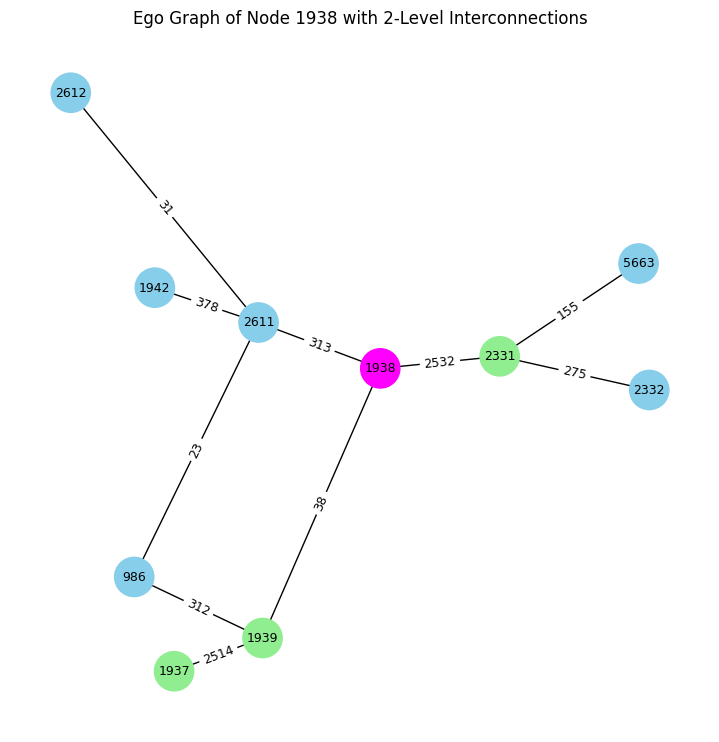

In [22]:
starting_node = 1938  # Define the starting node.

# Generate the ego graph for 2 hops (2 levels of interconnected nodes).
subgraph = nx.ego_graph(G, n=starting_node, radius=2)

pos = nx.spring_layout(subgraph, seed=52) # seed=52
pos[1937] = (pos[1937][0] - 0.1, pos[1937][1])  # Adjust x for node 1937  This is needed just for the clearer visualization.
pos[1938] = (pos[1938][0] - 0.1, pos[1938][1])  # Adjust x for node 1938
pos[1939] = (pos[1939][0] + 0.1, pos[1939][1])  # Adjust x for node 1939

# - 'magenta' for the ego node (starting_node and also a "bridge" node)
# - 'lightgreen' for nodes 1937, 1939, and 2331
# - 'skyblue' for the rest
special_nodes = {1937, 1939, 2331}
node_colors = [
    'magenta' if node == starting_node else
    'lightgreen' if node in special_nodes else
    'skyblue'
    for node in subgraph.nodes()
]

# Prepare edge labels (weights)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')

# Plot the subgraph
plt.figure(figsize=(7, 7))
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors,  # color ego node differently.
    edge_color='black', node_size=800, font_size=9)

# Add edge labels for weights
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=9)
plt.title(f"Ego Graph of Node {starting_node} with 2-Level Interconnections")
plt.show()

Four Bridge Nodes: (1937, 1939), (1939, 1938), (1938, 2331). If you move node "1937" to the right, so that it's in the same part with <br> the node "2331" it would make sense later in my actual map plotting :) As it depicts one bridge where each edge indicated one direction of traffic.

<b>Let's have a look at Separator Nodes (Articulation Points) </b>

In [23]:
print("The total number of Separator Nodes:", df[df['Separator']==1].shape[0])
# if "Separator" = 1 then this node is a separator (Articulation Point)

The total number of Separator Nodes: 1336


A lot of Articulation Points are present in the graph, I want to leave only those who are more "important", meaning which <br>
have also relatively high RawComm and Betweenness score and somewhat medium Closeness score.

In [24]:
df[(df['Separator']==1) & (df['Degree']==5)].reset_index(drop=True)

,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
0,389,5,1428,0.002291,0.000094,2.391203,1,208,3055,721,1036
1,3699,5,989,0.039739,0.000090,2.470460,1,466,442,1196,585
2,6115,5,1067,0.001303,0.000095,2.248322,1,407,3786,593,2153


In [25]:
df[(df['Separator']==1)].describe()

,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.0,1336.000000,1336.000000,1336.000000,1336.000000
mean,4389.757485,3.143713,592.222305,0.005741,0.000070,1.994631,1.0,880.892964,3730.098802,4248.976048,3885.112275
std,2096.357284,0.459936,418.761351,0.017216,0.000016,0.299033,0.0,318.172720,1485.293931,2162.913458,1748.925275
min,60.000000,2.000000,51.000000,0.000261,0.000038,0.994540,1.0,6.000000,2.000000,79.000000,34.000000
25%,2835.250000,3.000000,314.750000,0.000521,0.000057,1.820221,1.0,698.000000,2770.000000,2319.750000,2581.500000
50%,4675.000000,3.000000,483.000000,0.000982,0.000069,2.019039,1.0,957.000000,4150.500000,4490.000000,4095.500000
75%,6168.000000,3.000000,742.000000,0.002862,0.000084,2.201430,1.0,1125.250000,4813.000000,6138.500000,5328.750000
max,7663.000000,5.000000,3446.000000,0.187168,0.000102,2.755425,1.0,1389.000000,5354.000000,7670.000000,6813.000000


In [26]:
# First filter: separators with specific rank conditions. 
# Preferebly high or medium measures.
separators = df[df['Separator'] == 1]
filtered_separators = separators[
    (separators['Betweenness Rank'] <= 2000) & 
    (separators['Closeness Rank'] <= 3800) & 
    (separators['RawComm Rank'] <= 3000)]

# Second filter: separators with Degree == 5
degree_5_separators = df[(df['Separator'] == 1) & (df['Degree'] == 5)].reset_index(drop=True)

# Concatenate the two DataFrames.
articulation_points = pd.concat([filtered_separators, degree_5_separators], ignore_index=True)
articulation_points = articulation_points.drop_duplicates().reset_index(drop=True)  # during the concatenation some of the same nodes were added.

When I ran the code above for the <b>first filter</b> only I noticed that nodes with 5 degrees got excluded. <br>
I think the Separator nodes with such high degree should be present in my final conclusion. That's why I added the <b>second filter</b> and concatenated them.

In [27]:
print('Shape of the dataframe:', articulation_points.shape)
articulation_points.sort_values(['RawComm Rank']).reset_index(drop=True).head(30)

Shape of the dataframe: (64, 11)


,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
0,5777,3,549,0.046558,0.000089,2.704257,1,891,354,1337,65
1,5184,4,1010,0.153186,0.000091,2.668597,1,450,32,1053,84
2,361,4,1339,0.055869,0.000088,2.603414,1,253,258,1424,172
3,2953,4,876,0.054231,0.000085,2.564836,1,566,277,2074,253
4,5674,4,725,0.015868,0.000079,2.559414,1,715,1107,3358,262
5,1333,4,651,0.023973,0.000077,2.536816,1,789,775,3636,335
6,3129,4,725,0.014691,0.000094,2.534987,1,715,1165,704,344
7,6502,4,494,0.016260,0.000080,2.497626,1,946,1087,3217,463
8,6669,4,2693,0.020664,0.000079,2.489537,1,31,883,3423,487
9,7200,3,319,0.139270,0.000102,2.487917,1,1121,56,108,493


In [28]:
# Let's store separator nodes to this variable.
separator_nodes = articulation_points['Node'].to_list()
print("Number of final Separator Nodes:", len(separator_nodes))

Number of final Separator Nodes: 64


Let's examine if my previously defined "Bridge" nodes are also "Separator" nodes.

In [29]:
if_nodes_separators = [node if node in separator_nodes else 0 for node in bridge_nodes]  # if 0 then the node isn't a "separator".
if_nodes_separators

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Maybe if I compare my "Bridges" to all of the "Separators" in the graph something matches?

In [30]:
if_nodes_separators = [node if node in separators['Node'].to_list() else 0 for node in bridge_nodes] 
if_nodes_separators

[0, 0, 0, 0, 6314, 0, 0, 3426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Yes, two nodes '6314' and '3426' are also "Separators". Which I thought would happen. That makes these bridges even more important.

<b>Let's investigate Leaf Nodes </b> <br>

They are: quiet residential areas and dead-ends. Can be located on the outskirts of the city but also in the city center. Basically anywhere. <br>
 All the nodes that have node degree equal to 1.

In [31]:
df[df['Degree']==1].describe()

,Node,Degree,Strength,Betweenness,Closeness,RawComm,Separator,Strength Rank,Betweenness Rank,Closeness Rank,RawComm Rank
count,1268.000000,1268.0,1268.000000,1268.0,1268.000000,1268.000000,1268.0,1268.000000,1268.0,1268.000000,1268.000000
mean,5146.286278,1.0,205.181388,0.0,0.000069,1.315861,0.0,1236.298896,5859.0,4322.380126,6468.572555
std,1964.898864,0.0,204.984297,0.0,0.000015,0.218987,0.0,195.779094,0.0,2118.905192,346.096850
min,143.000000,1.0,2.000000,0.0,0.000038,0.703463,0.0,111.000000,5859.0,138.000000,3508.000000
25%,3825.250000,1.0,74.750000,0.0,0.000057,1.162718,0.0,1175.000000,5859.0,2441.500000,6346.750000
50%,5713.000000,1.0,139.000000,0.0,0.000069,1.305788,0.0,1301.000000,5859.0,4544.000000,6547.000000
75%,6777.500000,1.0,265.000000,0.0,0.000083,1.464661,0.0,1365.250000,5859.0,6167.250000,6711.250000
max,7676.000000,1.0,1795.000000,0.0,0.000101,2.095856,0.0,1431.000000,5859.0,7674.000000,6836.000000


Betweenness is 0, Strength (total road lengths of the node) is quite small. So, it perfectly makes sense. <br>
I could assign the role of a "dead-end" to these nodes, but I don't think they are useful for further analysis. That's why I'll skip them.<br>
***
In conclusion I assigned the following roles to some of the nodes: <br>
1. <b>20 "Bridges"</b> - both literally and figuratively bridges that connect different communities. Have very long road lengths coming to/from them. <br>
2. <b>64 "Separators"</b> - could be thought as bridges as well but with an even more strategic role and responsobility.

<b>Bridges</b>: <br>
1. Represent key high-traffic and strategically important nodes. <br>
2. Act as connectors between different communities or regions, similar to separator nodes, but with <br>
a focus on their role in traffic flow rather than overall connectivity.
3. The importance of these nodes is added with the fact that they have long road lengths, making it difficult to find alterantives <br>
if this bridge fails.

<b>Separators</b>: <br>
1. Critical nodes that, if removed, would disconnect the graph or significantly disrupt the connectivity of road network.
2. Removing these nodes (e.g., due to roadworks, accidents, or infrastructure failure) could isolate parts of the network or <br>
force traffic to take significantly longer detours. <br>
3. From a network vulnerability or resilience perspective, separator nodes are potential bottlenecks.
4. The nodes represent high-risk, high-impact locations in the city network.

##### <b> Task 7. Community Discovery </b>

<b>Girvan-Newman Algorithm </b> <br>
Girvan-Newman interprets weights as distances or costs. Since my road network already uses edge weights as distances (road lengths), <br> 
I don’t need to invert them.

In [ ]:
def most_valuable_edge(G):
    # Calculate edge betweenness centrality, considering weights
    centrality = nx.edge_betweenness_centrality(G, weight='weight')
    # Return the edge with the maximum centrality
    return max(centrality, key=centrality.get)

# Run the Girvan-Newman algorithm with the custom edge function
gn_generator = nx.community.girvan_newman(G, most_valuable_edge=most_valuable_edge)

# List to store the resulting communities.
communities_list = []

# Run the generator and stop when we have exactly 30 communities.
for i, communities in enumerate(gn_generator):
    print(f"After {i+1} iteration, the number of communities: {len(communities)}")
    # Check the number of connected components (communities) in the current graph.
    if len(communities) == 30:  # Stop once we've detected 30 communities.
        communities_list.append(communities)
        break

# Print the communities and their number
for i, communities in enumerate(communities_list):
    print(f"Iteration {i + 1} (the number of communities: {len(communities)}): {communities}")

This algorithm was running for 80 mins and didn't even get to the first iteration, that's why I can't use it unfortunately. It's too slow to run. <br>

<b>Label Propagation Algorithm (LPA)</b> <br>
LPA considers the weights of edges to prioritize stronger connections, this is why I need to inverse my weights before applying this algorithm. <br> My road lengths (weights) correspond to "costs", by inverting them I will make my shorter roads have higher connection strength.

In [32]:
for u, v, data in G.edges(data=True):
    data['inverted_weight'] = 1 / data['weight']  # Inverse of road length.

In [33]:
# Label Propagation Algorithm (LPA)
lpa_communities = nx.community.asyn_lpa_communities(G, weight='inverted_weight', seed=80)

# Convert to a list of communities
lpa_communities = [list(community) for community in lpa_communities]
print(f"Number of communities detected: {len(lpa_communities)}")

Number of communities detected: 2261


In [34]:
# Calculate community sizes
lpa_community_sizes = [len(community) for community in lpa_communities]

# Compute the average community size
average_community_size = sum(lpa_community_sizes) / len(lpa_community_sizes)
print(f"Average Community Size: {average_community_size:.2f}")

Average Community Size: 3.40


In [35]:
from networkx.algorithms.community.quality import modularity

# Convert to a set of frozensets for modularity calculation:
communities = [set(community) for community in lpa_communities]
lpa_mod_score = modularity(G, communities, weight='inverted_weight')
print(f"Modularity: {lpa_mod_score}")

Modularity: 0.7920781194511621


The range of <b>Modularity</b> is from <b>0</b> to <b>1</b> for realistic, meaningful community structures. But can also be negative. <br>
Modularity is aglobal measure of how well the entire graph is partitioned into communities. <br>
Actually, <b>Modularity</b> of <b>0.79</b> indicates a strong community structure. But the fact that I have 2261 communities makes me sad, as it's too much for my city. <br>
We can also see that the average <b>community size</b> is <b>3.4</b> nodes which is just meaningless. So, I will not use this method for my final decision.

<b>Louvain Algorithm </b> <br>

In [36]:
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import modularity

In [37]:
louvain_communities_result = list(louvain_communities(G, weight='inverted_weight', seed=88, resolution=0.05)) # inverted_weight
num_communities = len(louvain_communities_result)
print(f"Total number of communities detected: {num_communities}")

# Step 1: Create a mapping of nodes to community labels
node_to_community = {}
for community_label, community in enumerate(louvain_communities_result):
    for node in community:
        node_to_community[node] = community_label

Total number of communities detected: 26


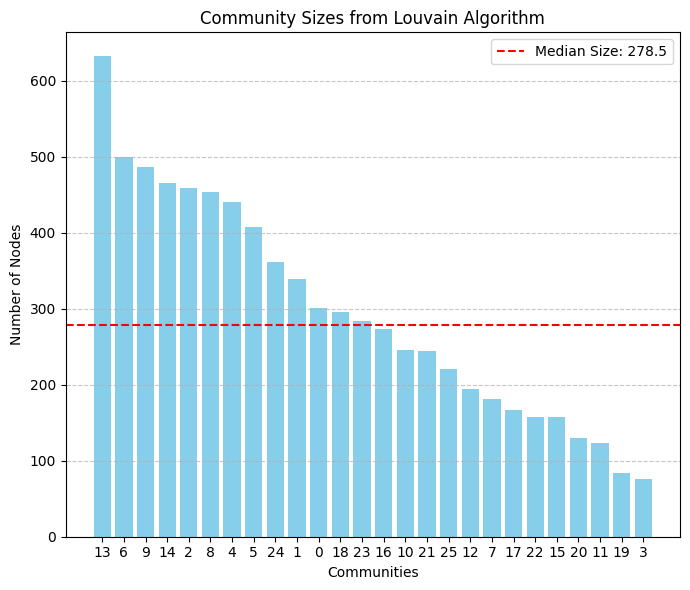

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# the number of nodes in each community.
community_count = Counter(node_to_community.values())
sorted_community_sizes = sorted(community_count.values(), reverse=True)
community_labels = [str(label) for label in sorted(community_count, key=community_count.get, reverse=True)]

# find the median of community sizes.
median_size = np.median(sorted_community_sizes)

plt.figure(figsize=(7, 6))
plt.bar(range(1, len(sorted_community_sizes) + 1), sorted_community_sizes, color='skyblue')
plt.axhline(y=median_size, color='red', linestyle='--', label=f'Median Size: {median_size:.1f}')

plt.xticks(range(1, len(sorted_community_sizes) + 1), community_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid for better visualization
plt.xlabel('Communities')
plt.ylabel('Number of Nodes')
plt.title('Community Sizes from Louvain Algorithm')
plt.tight_layout()  # Ensure labels fit within the figure
plt.show()

In [39]:
# convert the list of sets to a format suitable for modularity calculation (list of frozensets).
communities_frozensets = [frozenset(community) for community in louvain_communities_result]

# the modularity of the communities.
louvain_mod_score = modularity(G, communities_frozensets, weight='inverted_weight')
print(f"Modularity: {louvain_mod_score}")

Modularity: 0.949586946880725


In [40]:
df = pd.DataFrame({
    "Algorithm": ["Label Propagation Algorithm (LPA)", "Louvain Algorithm"],
    "Number of Communities": [len(lpa_communities), num_communities],
    "Average Community Size": [average_community_size, sum(sorted_community_sizes) / len(sorted_community_sizes)],
    "Modularity Score": [lpa_mod_score, louvain_mod_score]
})
df = df.round({"Average Community Size": 1, "Modularity Score": 3})
df

,Algorithm,Number of Communities,Average Community Size,Modularity Score
0,Label Propagation Algorithm (LPA),2261,3.4,0.792
1,Louvain Algorithm,26,295.3,0.950


We can see that the number of communities produced by LPA is too much, but as far as I know this is an expected behaviour from this method. <br>
LPA gives 0.792 modularity score which is actually quite good, but Louvain produced better communities and better modularity score. That's why <br> I'm going to choose <b>Louvain Algorithm</b> as my final decision and continue exploring my community membership of the central nodes. <br>

Let's get some more insights about Louvain method first.

In [41]:
inter_community_edges = 0

# iterate over all edges in the graph:
for u, v in G.edges():
    if node_to_community[u] != node_to_community[v]:
        inter_community_edges += 1

In [42]:
# average inter-community edges per community.
inter_community_edges_per_community = inter_community_edges / num_communities if num_communities > 0 else 0
print(f"Inter-community edges per community: {inter_community_edges_per_community:.1f}")

Inter-community edges per community: 5.0


In [43]:
# total number of edges in the graph.
total_edges = G.number_of_edges()

# get the proportion of inter-community edges.
inter_community_fraction = inter_community_edges / total_edges

print(f"Number of inter-community edges: {inter_community_edges}")
print(f"Proportion of inter-community edges: {inter_community_fraction:.3f}")


Number of inter-community edges: 130
Proportion of inter-community edges: 0.012


In [44]:
# the size of each community.
community_sizes = {label: sum(1 for node in node_to_community if node_to_community[node] == label) for label in set(node_to_community.values())}

# compute inter-community edges normalized by community size.
normalized_inter_community_edges = inter_community_edges / sum(community_sizes.values())
print(f"Inter-community edges normalized by community size: {normalized_inter_community_edges:.3f}")

Inter-community edges normalized by community size: 0.017


These communities correspond to neighborhoods, districts or areas with high internal connectivity. <br>
My groups are densely connected internally, while having relatively fewer connections to outside of their community. <br>

<b> Let's Investigate "Bridge" Nodes </b>

In [45]:
# check which community each bridge node belongs to.
bridge_nodes_communities = {node: node_to_community[node] for node in bridge_nodes}

for node, community_label in bridge_nodes_communities.items():
    print(f"Bridge Node {node} belongs to community {community_label}")

Bridge Node 2078 belongs to community 19
Bridge Node 611 belongs to community 5
Bridge Node 208 belongs to community 16
Bridge Node 2079 belongs to community 16
Bridge Node 6314 belongs to community 16
Bridge Node 2634 belongs to community 16
Bridge Node 652 belongs to community 16
Bridge Node 3426 belongs to community 15
Bridge Node 1937 belongs to community 4
Bridge Node 1939 belongs to community 24
Bridge Node 1938 belongs to community 24
Bridge Node 2331 belongs to community 4
Bridge Node 3128 belongs to community 0
Bridge Node 3097 belongs to community 10
Bridge Node 935 belongs to community 13
Bridge Node 2035 belongs to community 18
Bridge Node 341 belongs to community 23
Bridge Node 5820 belongs to community 16
Bridge Node 344 belongs to community 10
Bridge Node 641 belongs to community 16


In [46]:
from collections import Counter
# count how many bridge nodes belong to each community.
bridge_node_counts = Counter(bridge_nodes_communities.values())

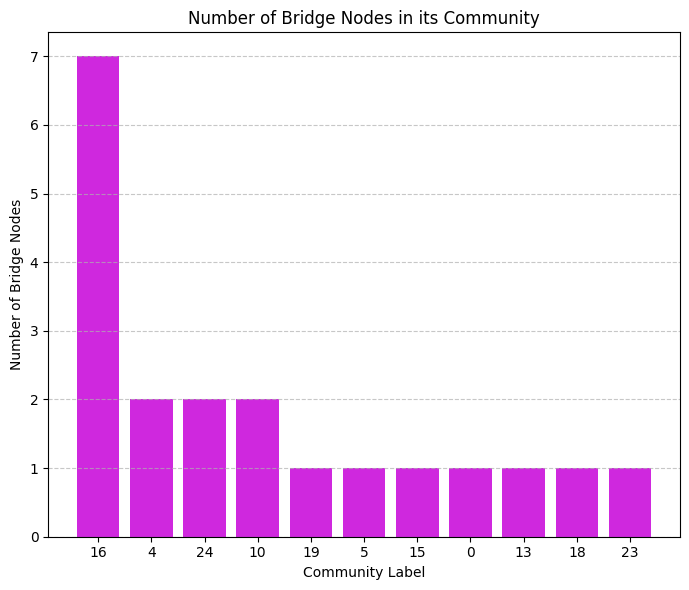

In [47]:
# sort the communities by the number of bridge nodes (descending).
sorted_communities = sorted(bridge_node_counts.items(), key=lambda x: x[1], reverse=True)

# extract the community labels and their corresponding bridge node counts.
community_labels, counts = zip(*sorted_communities)
community_labels = [str(label) for label in community_labels] 

plt.figure(figsize=(7, 6))
plt.bar(community_labels, counts, color='#cf28de')
plt.xlabel('Community Label')
plt.ylabel('Number of Bridge Nodes')
plt.title('Number of Bridge Nodes in its Community')
plt.yticks(range(0, max(counts) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid for better visualization.
plt.tight_layout()
plt.show()

<b> Let's Investigate "Separator" Nodes </b>

In [48]:
# check which community each bridge node belongs to.
separator_nodes_communities = {node: node_to_community[node] for node in separator_nodes}
# count how many bridge nodes belong to each community.
separator_nodes_counts = Counter(separator_nodes_communities.values())

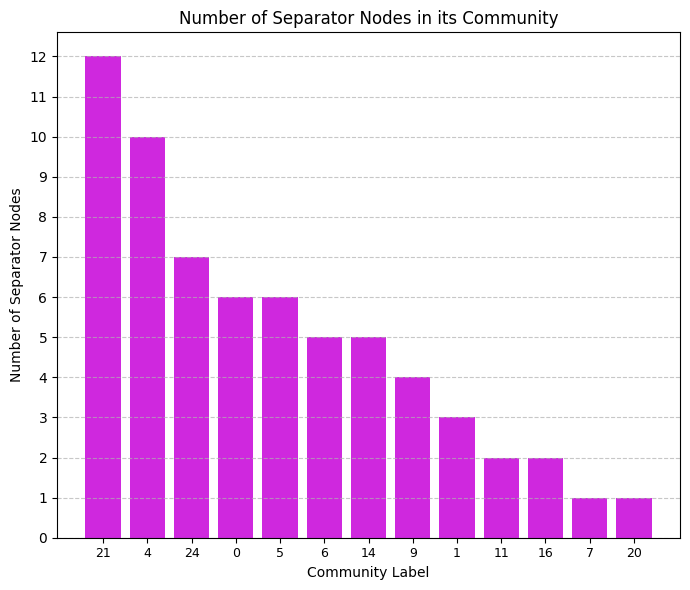

In [49]:
# sort the communities by the number of bridge nodes (descending).
sorted_communities = sorted(separator_nodes_counts.items(), key=lambda x: x[1], reverse=True)

# extract the community labels and their corresponding bridge node counts.
community_labels, counts = zip(*sorted_communities)
community_labels = [str(label) for label in community_labels] 

plt.figure(figsize=(7, 6))
plt.bar(community_labels, counts, color='#cf28de')
plt.xlabel('Community Label')
plt.ylabel('Number of Separator Nodes')
plt.title('Number of Separator Nodes in its Community')
plt.xticks(fontsize=9)  # Rotate by 90 degrees and set font size
plt.yticks(range(0, max(counts) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid for better visualization
plt.tight_layout()
plt.show()

In [50]:
# Find common communities between separator and bridge nodes.
common_communities = set(separator_nodes_communities.values()) & set(bridge_nodes_communities.values())

# Identify which nodes belong to these common communities.
common_community_nodes = {}
for community in common_communities:
    common_community_nodes[community] = {
        "separator_nodes": [node for node, community_label in separator_nodes_communities.items() if community_label == community],
        "bridge_nodes": [node for node, community_label in bridge_nodes_communities.items() if community_label == community]
    }

# Print the communities that have both bridge and separator nodes.
for community, nodes in common_community_nodes.items():
    print(f"Community {community} has:")
    print(f"  Bridge Nodes: {nodes['bridge_nodes']}")
    print(f"  Separator Nodes: {nodes['separator_nodes']}")
    print()

Community 0 has:
  Bridge Nodes: [3128]
  Separator Nodes: [226, 2953, 4434, 4455, 5674, 6502]

Community 4 has:
  Bridge Nodes: [1937, 2331]
  Separator Nodes: [1264, 1333, 1337, 1436, 4831, 5523, 5534, 5536, 5538, 5785]

Community 5 has:
  Bridge Nodes: [611]
  Separator Nodes: [2928, 2950, 3129, 5664, 5678, 7200]

Community 16 has:
  Bridge Nodes: [208, 2079, 6314, 2634, 652, 5820, 641]
  Separator Nodes: [5184, 6115]

Community 24 has:
  Bridge Nodes: [1939, 1938]
  Separator Nodes: [361, 2454, 2580, 2643, 5119, 7101, 7105]



I'd like to investigate Community "4" and Community "24".

In [51]:
# extract nodes belonging to community 24 and community 4.
community_24_nodes = {node for node, community in node_to_community.items() if community == 24}
community_4_nodes = {node for node, community in node_to_community.items() if community == 4}

# check for connections between the two communities:
connecting_edges = [(u, v) for u in community_24_nodes for v in community_4_nodes if G.has_edge(u, v)]

if connecting_edges:
    print(f"Community 24 is connected to Community 4 with {len(connecting_edges)} edge(s).")
else:
    print("Community 24 is not connected to Community 4.")

Community 24 is connected to Community 4 with 2 edge(s).


In [52]:
connecting_edges

[(1938, 2331), (1939, 1937)]

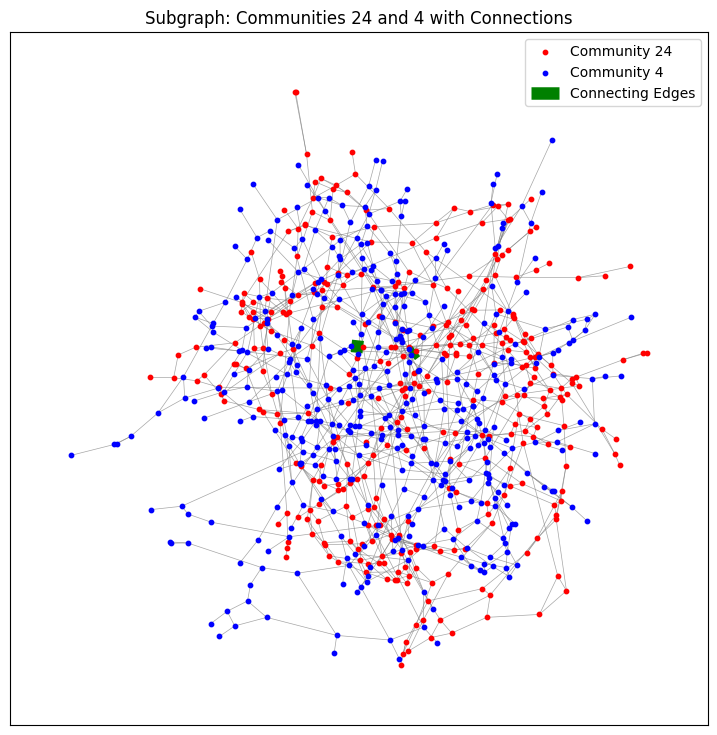

In [53]:
# combine the nodes from both communities.
selected_nodes = community_24_nodes.union(community_4_nodes)

# a subgraph containing only the selected nodes and their edges.
subgraph = G.subgraph(selected_nodes)
plt.figure(figsize=(9, 9))
pos = nx.spring_layout(subgraph, seed=25) # seed=67

nx.draw_networkx_nodes(subgraph, pos, nodelist=community_24_nodes, node_size=10, node_color='red', label='Community 24')
nx.draw_networkx_nodes(subgraph, pos, nodelist=community_4_nodes, node_size=10, node_color='blue', label='Community 4')
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.7, width=0.5)   # edges within the subgraph.
 
# Highlight connecting edges between the two communities.
connecting_edges = [(u, v) for u in community_24_nodes for v in community_4_nodes if subgraph.has_edge(u, v)]
nx.draw_networkx_edges(subgraph, pos, edgelist=connecting_edges, edge_color='green', width=9, label='Connecting Edges')

plt.legend(loc='best')
plt.title("Subgraph: Communities 24 and 4 with Connections")
plt.show()

It's very ugly and difficult to see on that graph. I will visualize it on a real geographical map. <br>

<b>Note*</b><br>
I will use "osmnx" library to plot my communities on a real geographical map. I know I'm supposed to use only networkx library, <br>
but I really want to see how my results look on the actual map of Dnipro. <br>
The following code was written with a help of ChatGPT, because it was very difficult to figure out the details. <br>
On top of that I had to do "reverse mapping" of my node names, as I changed my node labels for simplicity at the beginning. <br>
I also needed to use the original Dnipro graph file, as it contained geographical data needed for plotting. <br>
These visualizations are extra steps just for illustration purposes. 

In [54]:
import osmnx as ox
import json
# Load the original graph with geographic data
original_graph = ox.load_graphml("dnipro_road_network_origin.graphml")
# Load the short_mapping dictionary
with open("short_mapping.json", "r") as f:
    short_mapping = json.load(f)

# Reverse the mapping
reverse_mapping = {v: k for k, v in short_mapping.items()}
# reverse_mapping = {key: value for key, value in reverse_mapping.items()}
# Map community nodes back to the original graph
community_24_original = {int(reverse_mapping[node]) for node in community_24_nodes}
community_4_original = {int(reverse_mapping[node]) for node in community_4_nodes}

In [55]:
# combine all nodes from both communities.
all_community_nodes = community_24_original.union(community_4_original)

# extract the subgraph.
subgraph_with_geodata = original_graph.subgraph(all_community_nodes)

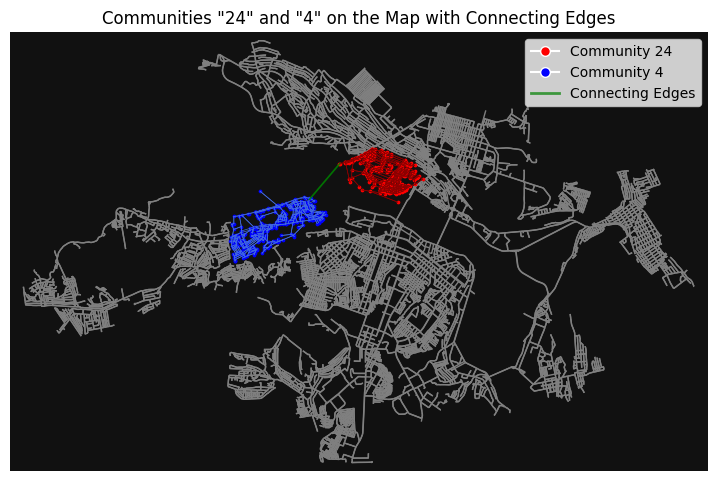

In [56]:
import osmnx as ox
import matplotlib.pyplot as plt

# subgraphs for each community.
community_24_subgraph = original_graph.subgraph(community_24_original)
community_4_subgraph = original_graph.subgraph(community_4_original)

# the full graph excluding nodes from both communities.
nodes_to_exclude = set(community_24_original).union(set(community_4_original))
remaining_nodes = [node for node in original_graph.nodes if node not in nodes_to_exclude]
remaining_graph = original_graph.subgraph(remaining_nodes)

# the full graph excluding Community 24 and Community 4 nodes.
fig, ax = ox.plot_graph(
    remaining_graph, 
    node_size=0, 
    edge_color="gray", 
    show=False, 
    close=False,
    figsize=(9, 9)
)

# Manually plot Community 24 nodes and edges.
for u, v, data in community_24_subgraph.edges(data=True):
    u_pos = original_graph.nodes[u]['x'], original_graph.nodes[u]['y']
    v_pos = original_graph.nodes[v]['x'], original_graph.nodes[v]['y']
    ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='darkred', linewidth=0.5)

for node in community_24_subgraph.nodes:
    node_pos = original_graph.nodes[node]['x'], original_graph.nodes[node]['y']
    ax.scatter(node_pos[0], node_pos[1], color='red', s=2.8)

# Manually plot Community 4 nodes and edges.
for u, v, data in community_4_subgraph.edges(data=True):
    u_pos = original_graph.nodes[u]['x'], original_graph.nodes[u]['y']
    v_pos = original_graph.nodes[v]['x'], original_graph.nodes[v]['y']
    ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='royalblue', linewidth=0.5)

for node in community_4_subgraph.nodes:
    node_pos = original_graph.nodes[node]['x'], original_graph.nodes[node]['y']
    ax.scatter(node_pos[0], node_pos[1], color='blue', s=2.8)

# Highlight edges connecting the two communities.
for u, v in connecting_edges:
    if u in reverse_mapping and v in reverse_mapping:
        # Retrieve the original node IDs using reverse_mapping.
        orig_u, orig_v = int(reverse_mapping[u]), int(reverse_mapping[v])
        
        # Check if either direction of the edge exists in the original graph.
        if original_graph.has_edge(orig_u, orig_v):
            u_pos = original_graph.nodes[orig_u]['x'], original_graph.nodes[orig_u]['y']
            v_pos = original_graph.nodes[orig_v]['x'], original_graph.nodes[orig_v]['y']
            ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='green', linewidth=1, alpha=0.7)
        elif original_graph.has_edge(orig_v, orig_u):  # Reverse direction
            u_pos = original_graph.nodes[orig_v]['x'], original_graph.nodes[orig_v]['y']
            v_pos = original_graph.nodes[orig_u]['x'], original_graph.nodes[orig_u]['y']
            ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='green', linewidth=1, alpha=0.7)

community_24_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label="Community 24")
community_4_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7, label="Community 4")
connecting_edge_legend = plt.Line2D([0], [0], color='green', linewidth=2, alpha=0.7, label="Connecting Edges")

# Add the community and connecting edge legends to the existing legend.
plt.legend(handles=[community_24_legend, community_4_legend, connecting_edge_legend], loc="best")

plt.title("""Communities "24" and "4" on the Map with Connecting Edges""")
plt.show()

The map shows the green bridge between these two communities. <br>
The two edges actually represent the same bridge. One traffic road lane for each edge. <br>
Funny thing. If you type: "Ego Graph of Node" (in Ctrl+F) you will find 2 level deep ego graph of these nodes that I previously plotted in Task 6. <br>

Anyway, let's plot all of my 26 communities on the same physical map.

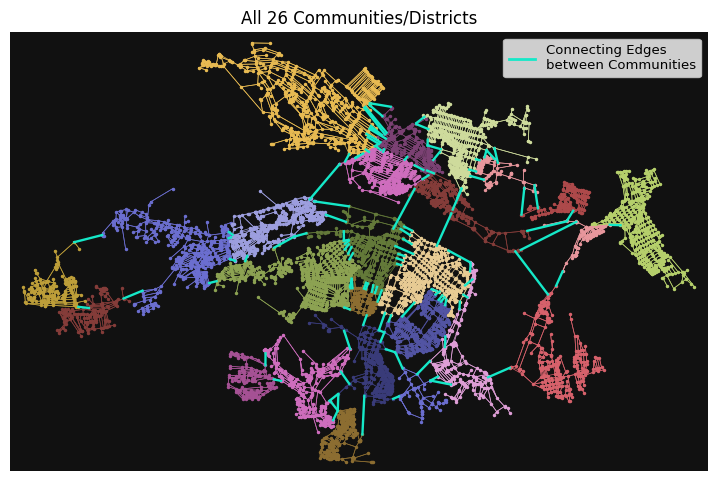

In [57]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import Counter
import itertools
from matplotlib.lines import Line2D

# count the number of nodes in each community.
community_count = Counter(node_to_community.values())

# create a color gradient for communities.
colormap = plt.colormaps['tab20b']  # Use the 'tab20', gist_rainbow, brg - very good,
# community_colors = {community: colormap(i / len(community_count)) for i, community in enumerate(community_count)}

community_colors = {
    community: colormap((i + 0.6) / len(community_count))  # Offset to adjust colors slightly
    for i, community in enumerate(community_count)
}

# subgraphs for each community.
subgraphs = {}
for community in community_count.keys():
    community_nodes = {node for node, community_id in node_to_community.items() if community_id == community}
    community_original_nodes = {int(reverse_mapping[node]) for node in community_nodes}
    subgraphs[community] = original_graph.subgraph(community_original_nodes)

# identify and store connecting edges between communities.
connecting_edges = set()

# iterate over each pair of communities to find edges between them.
for community_a, community_b in itertools.combinations(community_count.keys(), 2):
    # get the nodes for both communities
    community_a_nodes = {int(reverse_mapping[node]) for node, community_id in node_to_community.items() if community_id == community_a}
    community_b_nodes = {int(reverse_mapping[node]) for node, community_id in node_to_community.items() if community_id == community_b}

    # find edges that connect nodes from community_a to community_b.
    for u, v, data in original_graph.edges(data=True):
        if u in community_a_nodes and v in community_b_nodes:
            connecting_edges.add((u, v))

fig, ax = ox.plot_graph(
    original_graph, 
    node_size=0, 
    edge_color="none",  
    show=False, 
    close=False,
    figsize=(9, 9)
)

# plot each community and its edges.
for community, subgraph in subgraphs.items():
    # plot edges of the current community.
    for u, v, data in subgraph.edges(data=True):
        u_pos = original_graph.nodes[u]['x'], original_graph.nodes[u]['y']
        v_pos = original_graph.nodes[v]['x'], original_graph.nodes[v]['y']
        ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color=community_colors[community], linewidth=0.5)

    # plot nodes of the current community.
    for node in subgraph.nodes:
        node_pos = original_graph.nodes[node]['x'], original_graph.nodes[node]['y']
        ax.scatter(node_pos[0], node_pos[1], color=community_colors[community], s=2.2) 

# plot the connecting edges in a specific color (e.g., white).
for u, v in connecting_edges:
    u_pos = original_graph.nodes[u]['x'], original_graph.nodes[u]['y']
    v_pos = original_graph.nodes[v]['x'], original_graph.nodes[v]['y']
    ax.plot([u_pos[0], v_pos[0]], [u_pos[1], v_pos[1]], color='#15e8c8', linewidth=1.7)

legend_line = Line2D([0], [0], color='#15e8c8', lw=2, label='Connecting Edges\nbetween Communities') 
ax.legend(handles=[legend_line], loc='upper right', fontsize=9.5)
plt.title("All 26 Communities/Districts")
plt.show()

And below is the current 8 existing districts of Dnipro:

<img src="dnipro initial districts2.png" width="700">


##### <b> Task 8. Conclusions and Future Work </b>

1. In this project I downloaded <b>road network</b> data of the <b>city Dnipro</b>. 
2. I turned my data into undirected graph and removed self-loops.
3. I computed different graph properties. <b>Average node degree</b> was <b>2.83</b> and <b>average clustering coefficient</b> was <b>0.0468</b>. <br>
My graph was very sparse, which is typical for the road network.<br>
4. Centrality measures were calculated like: <b>Node Strength</b>, <b>Betweenness</b>, <b>Closeness</b>, <b>Raw Community Score</b>, <b>Separator Nodes</b>.
5. <b>20 "Bridge"</b> and <b>64 "Separator"</b> nodes roles were assigned to some nodes by filtering through different centrality metrics. <br>
Also <b>"Leaf"</b> nodes roles were determined but not used. <br>
6. <b>Louvain</b> Community Discovery algorithm was used and as the final method for identifying communities. <br>
<b>26 Communities/Regions</b> were discovered in Dnipro with <b>modularity</b> of <b>0.95</b>.

I would say that I managed to achieve my goal, namely to find current distribution of city districts. <br>
Instead of 8 regions in Dnipro, now there are 26 of them. <br>
##### <b>Potential Value</b><br>

* The boundaries between communities could indicate points of potential congestion or areas where inter-community transportation infrastructure <br>(e.g., bus routes, roads) could be improved.
* Knowing the structure of these communities urban planning could be implemented with better ideas. For example: schools, parks, hospitals.
* The community structure might correlate with socioeconomic factors, such as population density, income levels, or smth else. This information <br> can be used by city planners to address inequalities or target community-specific development programs. <br>

##### <b>The next course of action:</b> <br>

Overlap Analysis: <br>
* Compare the detected communities with the official 8 regions on the real geographical map. Analyze how the 26 communities <br>align with, split, or merge existing boundaries. <br>
* Overlay traffic flows and current public transport routes.
* Examine critical intersections/roads (bridge and separator nodes). Develop a backup/emergency route plan.
* Add time-series data (e.g., rush hour patterns) to understand how community boundaries shift throughout the day.
* Share insights with businesses (e.g., for advertisement) to optimize locations for stores, services or logistics hubs based on the detected areas. <br>
* Compare Dnipro’s road network communities with those of other cities to identify unique features or opportunities for improvement.

##### <b>Limitations and Future Work</b> <br>

1. I converted my data into an undirected graph, which resulted in the removal of many edges. In reality, roads are directed, meaning some <br>allow traffic in only one direction, while others permit two-way traffic. But undirected grah was required by the task itself. 
2. My raw community score function was customized and parameters q and p were perhaps not the best chosen.
3. I should have detected central nodes that were "Big Fish" in each community (local centers with shops etc.) or smth like that, but I didn't do it.
4. Girvan-Newman algorithm wasn't implemented unfortunately. I wish I could compare it with my Louvain one. <br>
Appart from that, I could run Asynchronous Fluid Communities algorithm and choose k=26 (number of communities) and compare it with my <br> Louvain's communities.

##### <b> Task 9. Standalone Task. Time Measurements </b>
The goal is to measure Girvan-Newman and Louvain algorithms run times and compare them. <br>
5, 10, 15, 20, 25, 30, 35, 40, 45 and 50 % of the total graph G will be randomly sampled and used for executing algorithms on it.

In [58]:
import random
import time
from networkx.algorithms.community import louvain_communities

# Function to calculate the most valuable edge for weighted Girvan-Newman.
def most_valuable_edge(G):
    # calculate edge betweenness centrality considering weights.
    centrality = nx.edge_betweenness_centrality(G, weight='weight')
    # return the edge with the maximum centrality.
    return max(centrality, key=centrality.get)

random.seed(80)
np.random.seed(80) 

# percentages of nodes to sample.
percentages = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# total number of nodes.
num_nodes = len(G.nodes)

# runtimes for both algorithms.
girvan_runtimes = []
louvain_runtimes = []

gn_communities = []
louvain_communities_list = []

# compare both algorithms on induced subgraphs:
for percentage in percentages:
    # number of nodes to sample.
    sample_size = int(num_nodes * percentage / 100)
    
    # randomly sample nodes.
    sampled_nodes = random.sample(list(G.nodes), sample_size)
    
    # subgraph of random n percentage.
    subgraph = G.subgraph(sampled_nodes).copy()

    # --- Girvan-Newman Algorithm (with weights) ---
    
    start_time = time.time()
    gn_generator = nx.community.girvan_newman(subgraph, most_valuable_edge=most_valuable_edge)

    for i, communities in enumerate(gn_generator):
        # stop after 10 levels of communities.
        if i == 9:  
            gn_communities.append(communities)
            break

    gn_runtime = time.time() - start_time
    girvan_runtimes.append((percentage, gn_runtime))
    
    # --- Louvain Algorithm ---
    start_time = time.time()
    louvain_comms = list(louvain_communities(subgraph, weight='inverted_weight', seed=88, resolution=0.05)) # inverted_weight)
    louvain_communities_list.append(louvain_comms)
    louvain_runtime = time.time() - start_time
    louvain_runtimes.append((percentage, louvain_runtime))
    
    # Print progress for current percentage
    print(f"Percentage: {percentage}% | Girvan-Newman: {gn_runtime:.2f}s | Louvain: {louvain_runtime:.2f}s")

Percentage: 5% | Girvan-Newman: 0.25s | Louvain: 0.02s
Percentage: 10% | Girvan-Newman: 0.91s | Louvain: 0.03s
Percentage: 15% | Girvan-Newman: 7.00s | Louvain: 0.05s
Percentage: 20% | Girvan-Newman: 16.35s | Louvain: 0.07s
Percentage: 25% | Girvan-Newman: 25.98s | Louvain: 0.07s
Percentage: 30% | Girvan-Newman: 55.53s | Louvain: 0.12s
Percentage: 35% | Girvan-Newman: 66.49s | Louvain: 0.12s
Percentage: 40% | Girvan-Newman: 102.38s | Louvain: 0.14s
Percentage: 45% | Girvan-Newman: 149.55s | Louvain: 0.18s
Percentage: 50% | Girvan-Newman: 230.55s | Louvain: 0.20s


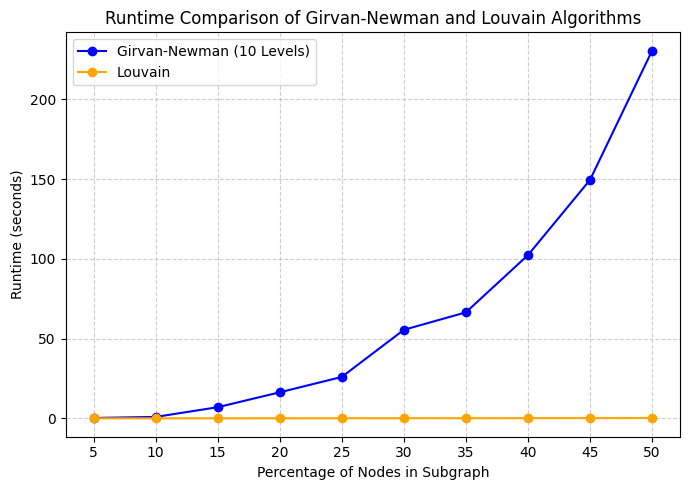

In [59]:
# get percentages and runtimes.
percentages = [p for p, _ in girvan_runtimes]
girvan_times = [t for _, t in girvan_runtimes]
louvain_times = [t for _, t in louvain_runtimes]

plt.figure(figsize=(7, 5))
plt.plot(percentages, girvan_times, label="Girvan-Newman (10 Levels)", marker='o', color='blue')
plt.plot(percentages, louvain_times, label="Louvain", marker='o', color='orange')

plt.title("Runtime Comparison of Girvan-Newman and Louvain Algorithms", fontsize=12)
plt.xlabel("Percentage of Nodes in Subgraph", fontsize=10)
plt.ylabel("Runtime (seconds)", fontsize=10)
plt.xticks(percentages)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

We can see that Girvan-Newman is much more slower than Louvain method. <br>
Girvan-Newman time complexity grows exponentially with the size of the graph. <br>
Louvain algorithm is computationally much more efficient and scales more linearly compared to the Girvan-Newman algorithm. 

![data mining photo.jpg](<attachment:data mining photo.jpg>)
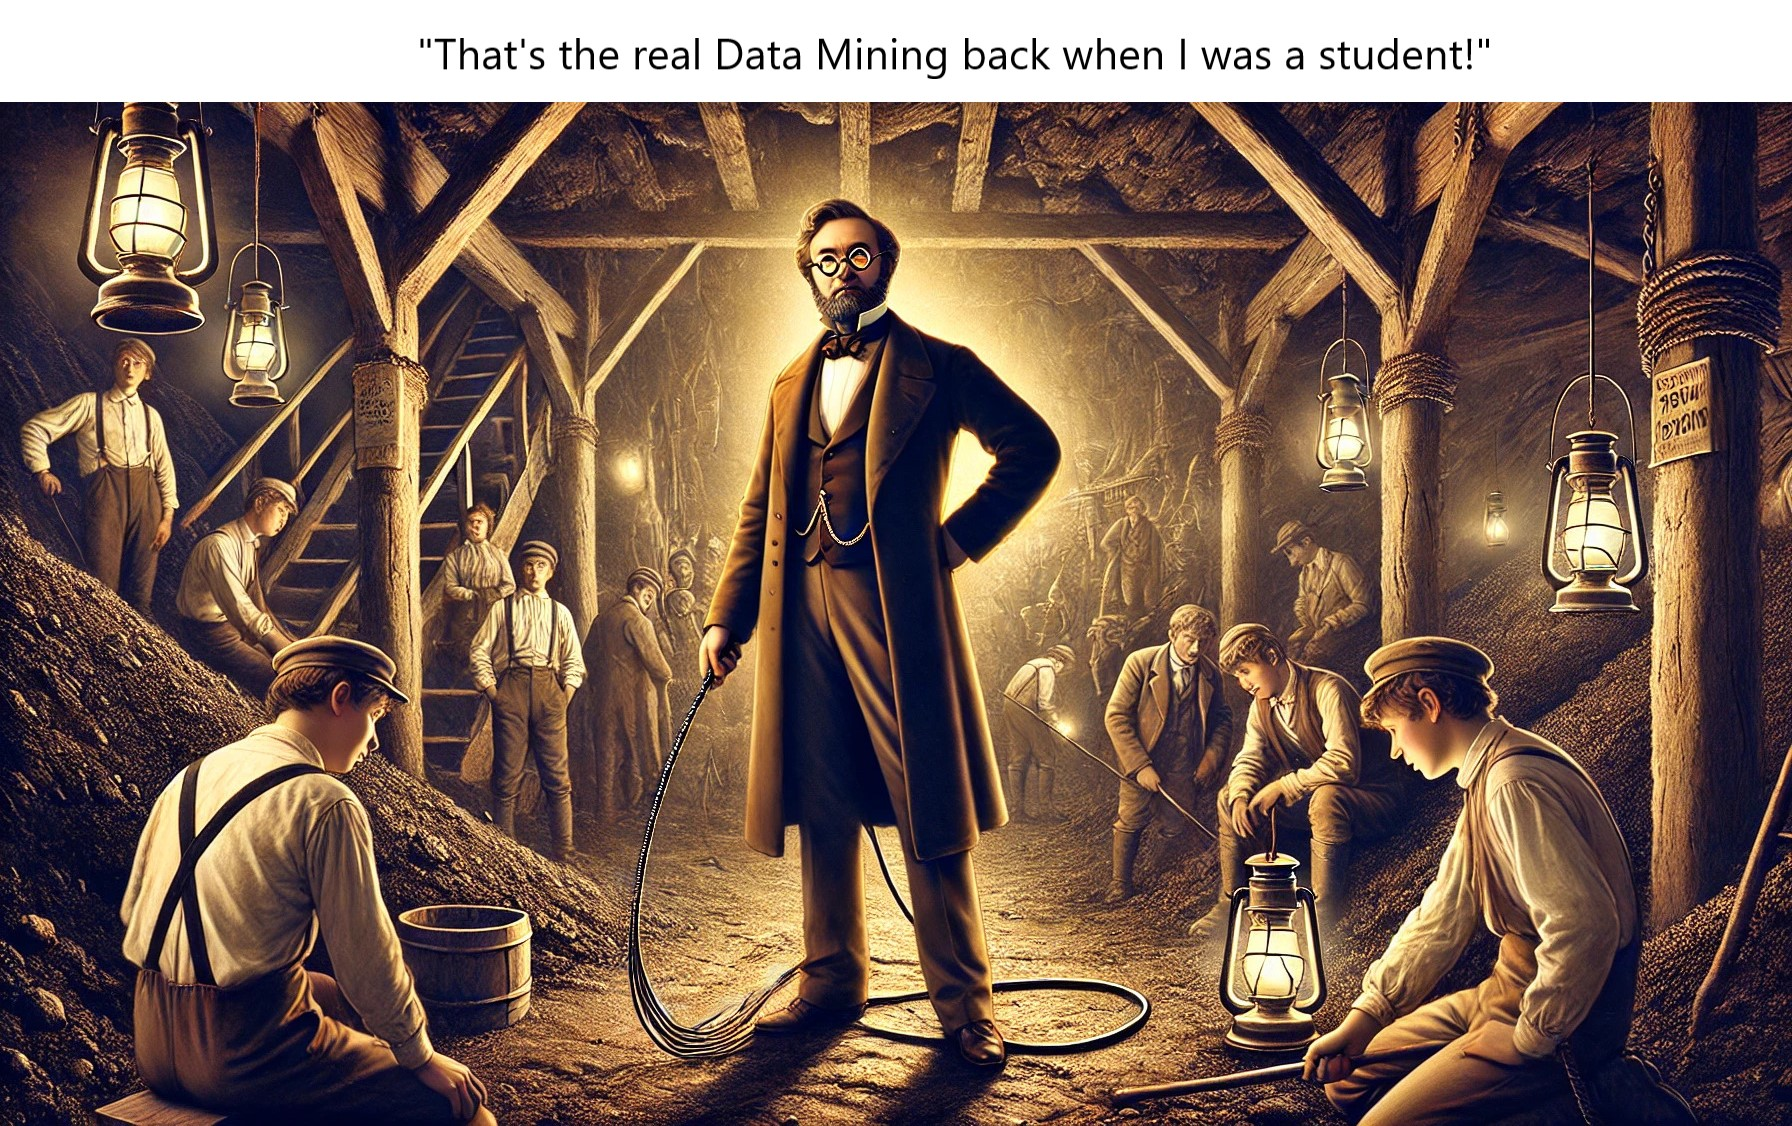